<a href="https://colab.research.google.com/github/bharathsanjai/Melanoma-CNN-Prediction/blob/main/Melanoma_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Running on GPU

import platform
import tensorflow as tf

print("Python version: ", platform.python_version())
print("TensorFlow version: ", tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU not found. Running on CPU.')
else:
    print('GPU found. Running on GPU.')

Python version:  3.10.12
TensorFlow version:  2.12.0
GPU found. Running on GPU.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [23]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/drive/My Drive/CNNN/Skin_cancer'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [24]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Create a dataset

In [25]:
batch_size = 32
img_height = 180
img_width = 180

In [26]:
# Train dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [27]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [28]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Visualize the data

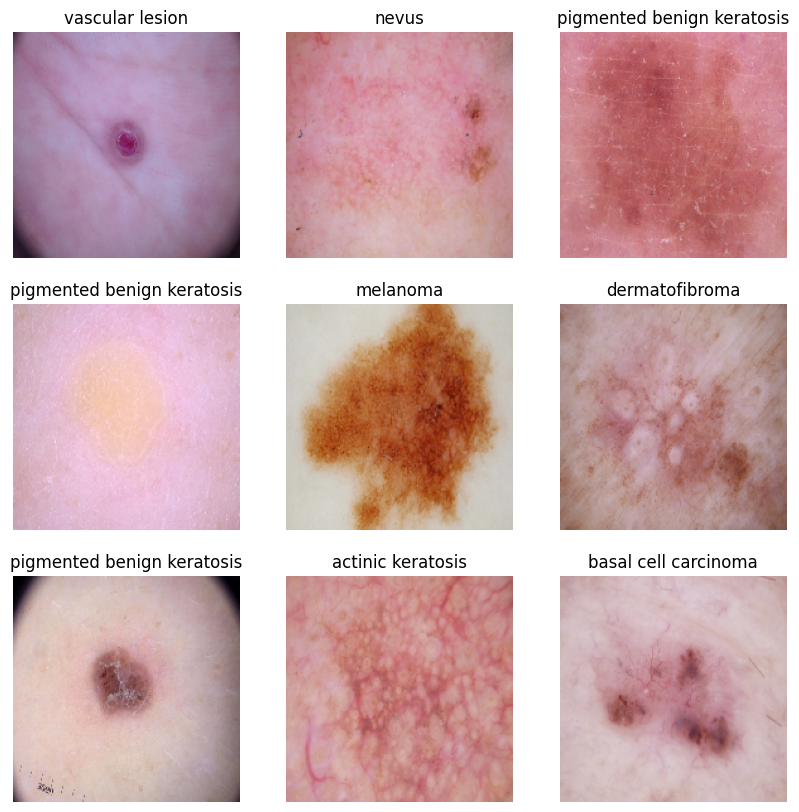

In [29]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Configure the dataset for performance

#### Dataset.cache

Keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

#### Dataset.prefetch

overlaps data preprocessing and model execution while training.

In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model


Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]¶

In [31]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model
Choose an appropirate optimiser and loss function for model training

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

Train the model

In [34]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 194s 809ms/step - loss: 2.1391 - accuracy: 0.2148 - val_loss: 1.9437 - val_accuracy: 0.2573
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.8022 - accuracy: 0.3465 - val_loss: 1.7055 - val_accuracy: 0.4183
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5716 - accuracy: 0.4604 - val_loss: 1.5073 - val_accuracy: 0.4922
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4790 - accuracy: 0.4872 - val_loss: 1.4741 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3511 - accuracy: 0.5340 - val_loss: 1.4300 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3007 - accuracy: 0.5508 - val_loss: 1.3675 - val_accuracy: 0.5526
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2047 - accuracy: 0.5725 - val_loss: 1.4623 - val_accuracy: 0.5391
Epoch 8/20

Visualizing training results

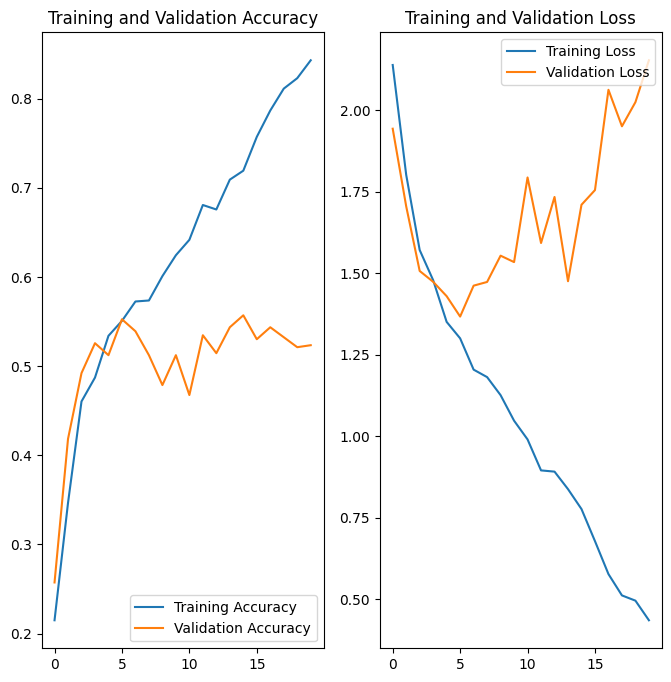

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Write your findings here

## Augumenations

In [36]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

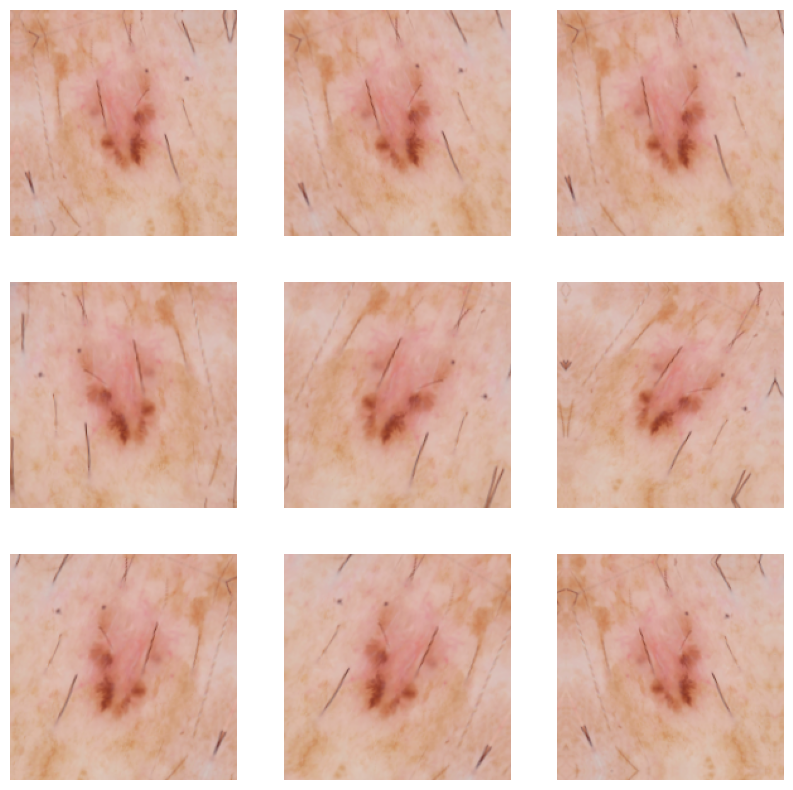

In [37]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Create the model, compile and train the model

In [38]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [41]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
56/56 [==============================] - 3s 31ms/step - loss: 2.5195 - accuracy: 0.1931 - val_loss: 2.0470 - val_accuracy: 0.1633
Epoch 2/15
56/56 [==============================] - 2s 27ms/step - loss: 1.8918 - accuracy: 0.3125 - val_loss: 1.8476 - val_accuracy: 0.3311
Epoch 3/15
56/56 [==============================] - 2s 27ms/step - loss: 1.7391 - accuracy: 0.3761 - val_loss: 1.7251 - val_accuracy: 0.3758
Epoch 4/15
56/56 [==============================] - 2s 30ms/step - loss: 1.6594 - accuracy: 0.4051 - val_loss: 1.6679 - val_accuracy: 0.4430
Epoch 5/15
56/56 [==============================] - 2s 28ms/step - loss: 1.6152 - accuracy: 0.4247 - val_loss: 1.6012 - val_accuracy: 0.4362
Epoch 6/15
56/56 [==============================] - 2s 28ms/step - loss: 1.5380 - accuracy: 0.4526 - val_loss: 1.5796 - val_accuracy: 0.4653
Epoch 7/15
56/56 [==============================] - 2s 28ms/step - loss: 1.5279 - accuracy: 0.4665 - val_loss: 1.5414 - val_accuracy: 0.4787
Epoch 8/15
56

Visualizing the results

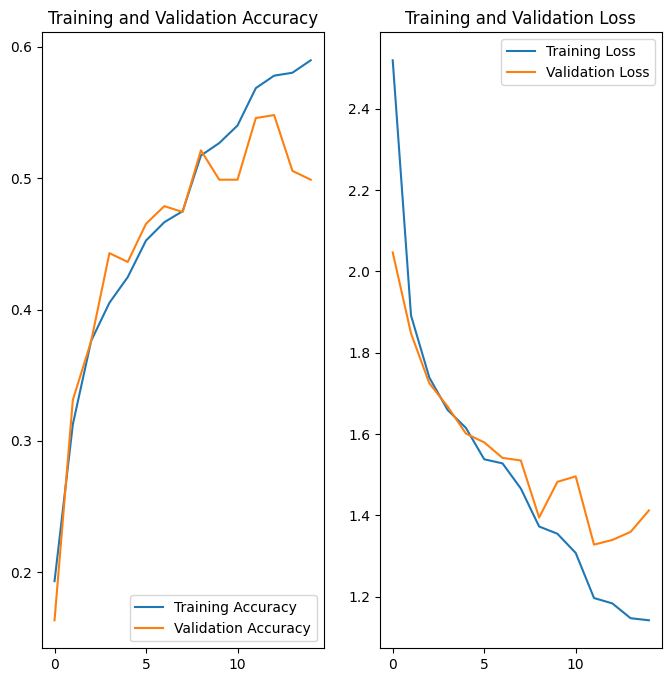

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Inference: Model has some improvements post adding dropout but still there is scope to recue the overfit by adding augumentation libraries

Find the distribution of classes in the training dataset.

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 1000x1000 with 0 Axes>

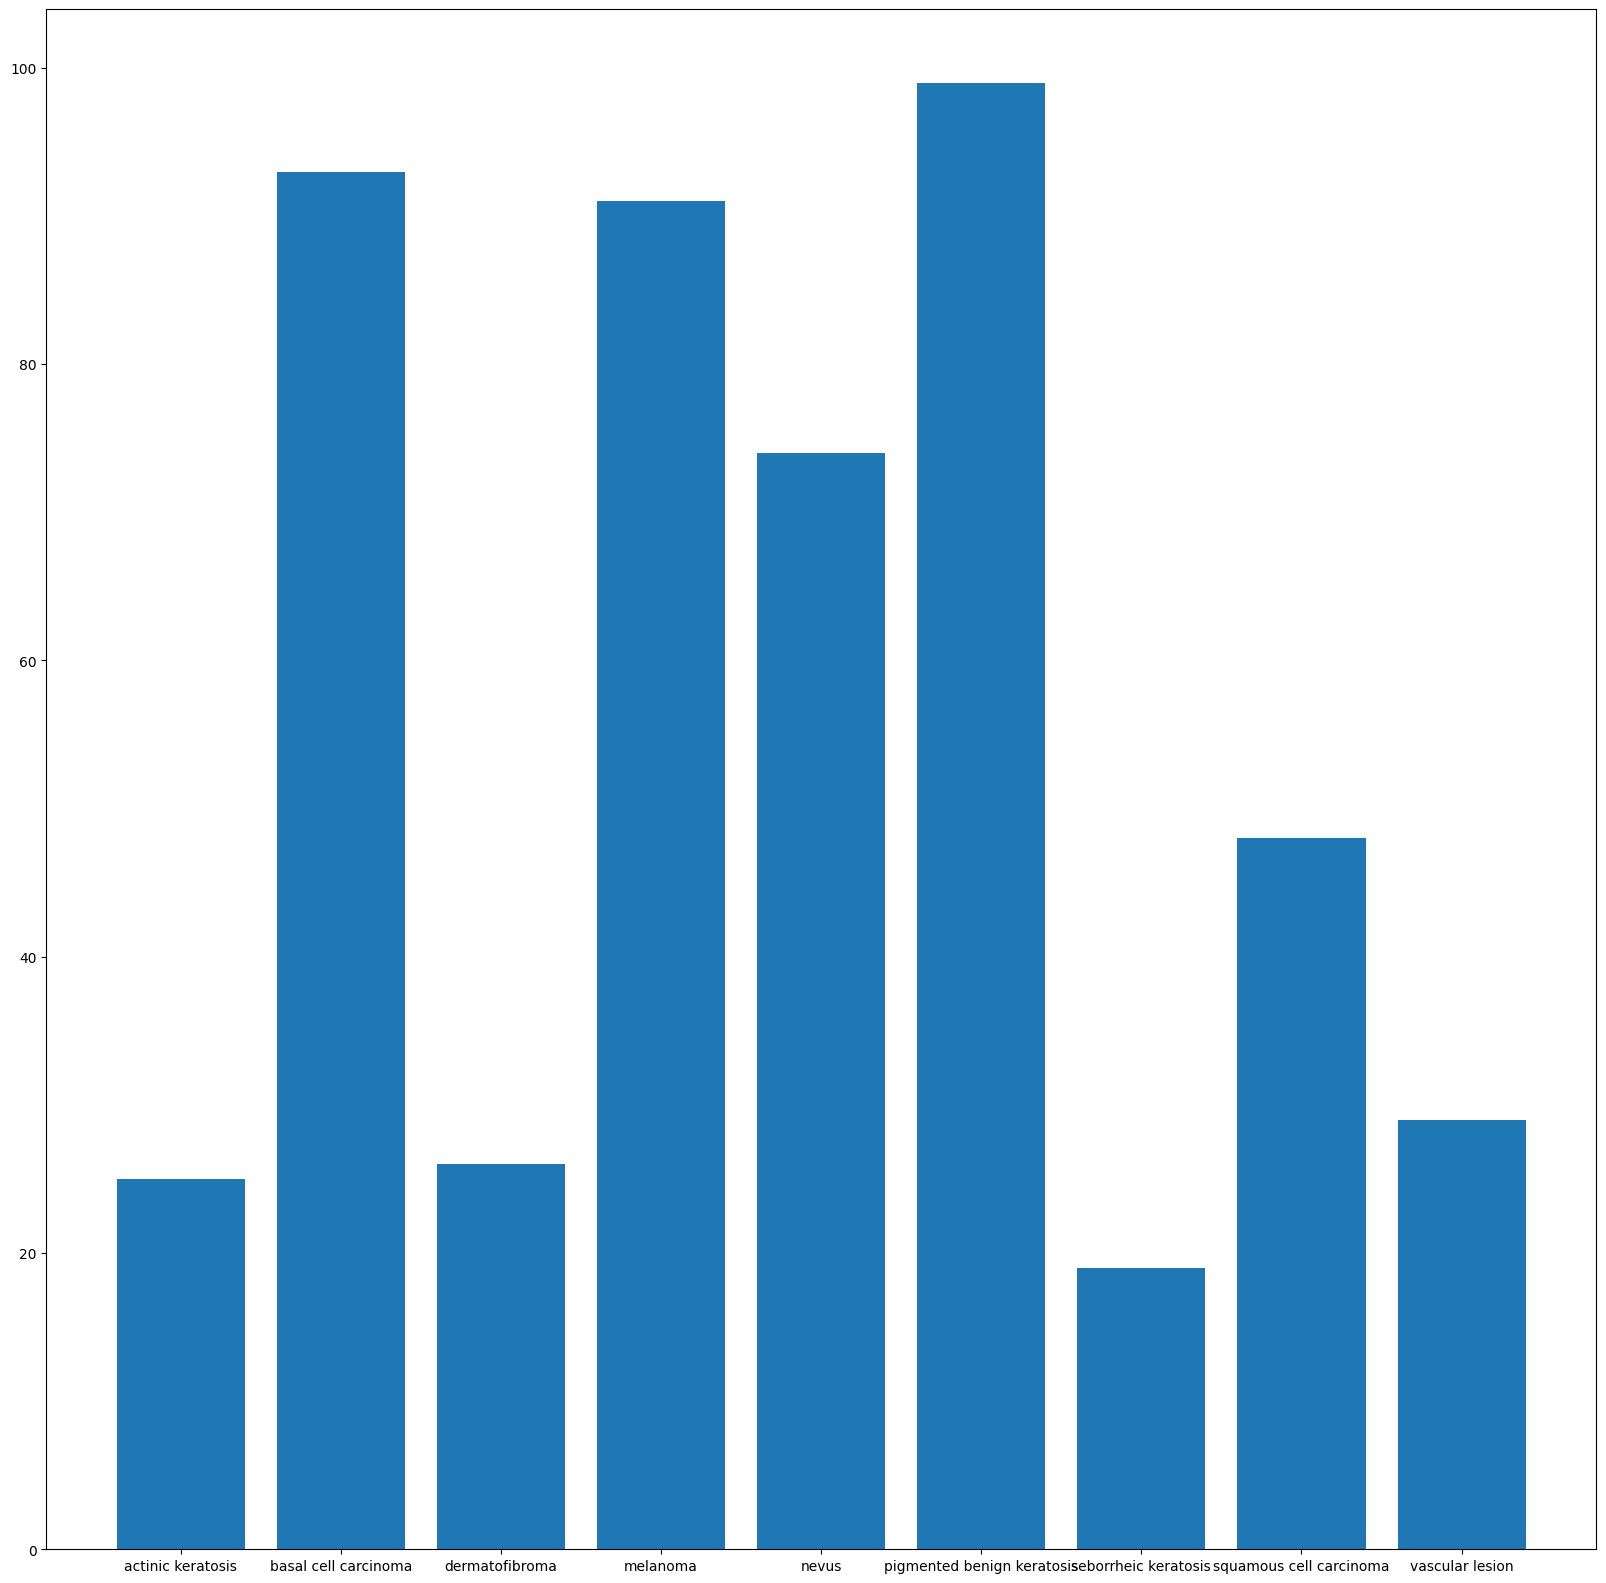

In [43]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i])

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

Rectify the class imbalance Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

Which class has the least number of samples?
 Actinic Keratosos and Seborrheic keratosis

Which classes dominate the data in terms proportionate number of samples?
Pigmented benign keratosis dominates the data of count more than 100 in training

In [44]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [45]:
path_to_training_dataset="/content/drive/My Drive/CNNN/Skin_cancer/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/CNNN/Skin_cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E9279F4BFD0>: 100%|██████████| 500/500 [00:20<00:00, 24.93 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/CNNN/Skin_cancer/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E9279CE64A0>: 100%|██████████| 500/500 [00:23<00:00, 21.21 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/CNNN/Skin_cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E927A4AAC80>: 100%|██████████| 500/500 [00:21<00:00, 23.67 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/CNNN/Skin_cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7E9279D97520>: 100%|██████████| 500/500 [01:20<00:00,  6.18 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/CNNN/Skin_cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7E93914A3430>: 100%|██████████| 500/500 [01:26<00:00,  5.80 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/CNNN/Skin_cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E9279F4BFD0>: 100%|██████████| 500/500 [00:17<00:00, 28.93 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/CNNN/Skin_cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E9279E643A0>: 100%|██████████| 500/500 [00:38<00:00, 12.83 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/CNNN/Skin_cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E92F0245360>: 100%|██████████| 500/500 [00:16<00:00, 30.07 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/CNNN/Skin_cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E92A4B72D70>: 100%|██████████| 500/500 [00:17<00:00, 27.80 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [46]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [47]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/My Drive/CNNN/Skin_cancer/Train/melanoma/output/melanoma_original_ISIC_0010364.jpg_441d6db3-0452-4ec4-986f-33910dd6998f.jpg',
 '/content/drive/My Drive/CNNN/Skin_cancer/Train/melanoma/output/melanoma_original_ISIC_0000466.jpg_2971ea8d-6784-4aea-9895-8121e54cd1ae.jpg',
 '/content/drive/My Drive/CNNN/Skin_cancer/Train/melanoma/output/melanoma_original_ISIC_0010923.jpg_3a9e17bb-f59e-48e8-934e-5603fba522ce.jpg',
 '/content/drive/My Drive/CNNN/Skin_cancer/Train/melanoma/output/melanoma_original_ISIC_0000305.jpg_aa56ff12-507d-49a8-a96b-711981ce7dc5.jpg',
 '/content/drive/My Drive/CNNN/Skin_cancer/Train/melanoma/output/melanoma_original_ISIC_0000310.jpg_f59584eb-f6ff-45b1-a1c1-23392c761caf.jpg',
 '/content/drive/My Drive/CNNN/Skin_cancer/Train/melanoma/output/melanoma_original_ISIC_0010555.jpg_bfb608c1-2b85-4a91-a64f-40e8d7f43456.jpg',
 '/content/drive/My Drive/CNNN/Skin_cancer/Train/melanoma/output/melanoma_original_ISIC_0010164.jpg_f6842468-3282-4b54-8bbe-07e03e799656.jpg',

In [48]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [49]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [50]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [51]:
new_df['Label'].value_counts()

melanoma                      500
seborrheic keratosis          500
squamous cell carcinoma       500
dermatofibroma                500
basal cell carcinoma          500
actinic keratosis             500
pigmented benign keratosis    500
nevus                         500
vascular lesion               500
Name: Label, dtype: int64

Train the model on the data created using Augmentor

In [52]:
batch_size = 32
img_height = 180
img_width = 180

Create a training dataset

In [53]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Create a validation dataset

In [54]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [55]:
from tensorflow.keras.layers import Dense, BatchNormalization
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  BatchNormalization(),
  layers.Dense(num_classes)
])

Compile your model (Choose optimizer and loss function appropriately)

In [56]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train your model

In [57]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 40s 211ms/step - loss: 1.7541 - accuracy: 0.3431 - val_loss: 3.1077 - val_accuracy: 0.2695
Epoch 2/50
169/169 [==============================] - 39s 224ms/step - loss: 1.5003 - accuracy: 0.4533 - val_loss: 3.2050 - val_accuracy: 0.2509
Epoch 3/50
169/169 [==============================] - 38s 222ms/step - loss: 1.3974 - accuracy: 0.4900 - val_loss: 2.7603 - val_accuracy: 0.2999
Epoch 4/50
169/169 [==============================] - 38s 221ms/step - loss: 1.2885 - accuracy: 0.5243 - val_loss: 2.2865 - val_accuracy: 0.2524
Epoch 5/50
169/169 [==============================] - 41s 236ms/step - loss: 1.1984 - accuracy: 0.5638 - val_loss: 2.2886 - val_accuracy: 0.2472
Epoch 6/50
169/169 [==============================] - 41s 235ms/step - loss: 1.1009 - accuracy: 0.5957 - val_loss: 1.9627 - val_accuracy: 0.3111
Epoch 7/50
169/169 [==============================] - 40s 232ms/step - loss: 1.0384 - accuracy: 0.6319 - val_loss: 1.7985 - val_ac

Visualise the results

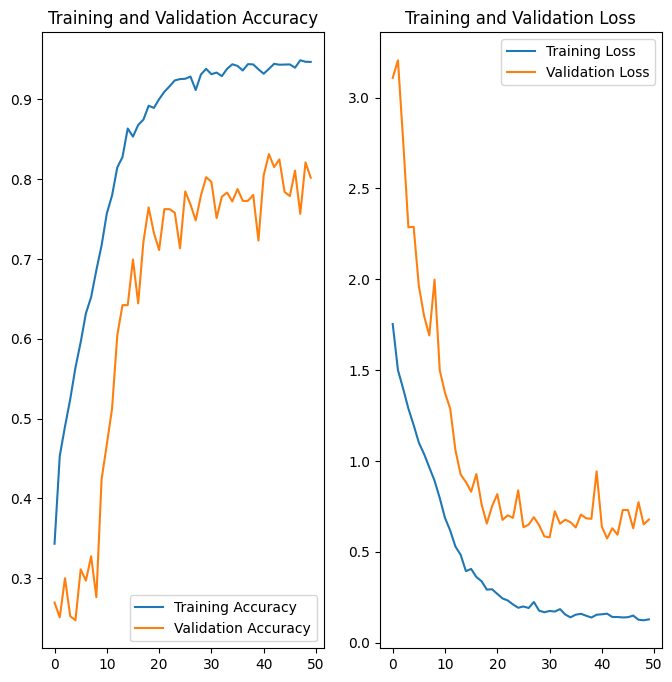

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Did you get rid of underfitting/overfitting? Did class rebalance help?

